# PDF2HTML STF

In [1]:
%pip install pypdf numpy python-poppler
#from pypdf import PdfReader
import requests
from dataclasses import dataclass
import numpy as np
import functools
import poppler
import IPython
from IPython.display import display
import PIL
import matplotlib
from matplotlib import pyplot as plt
import tempfile

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


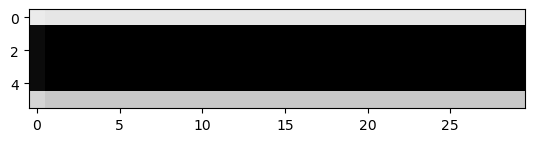

[[235 230 230 230 230 230 230 230 230 230 230 230 230 230 230 230 230 230
  230 230 230 230 230 230 230 230 230 230 230 230]
 [ 11   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [ 11   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [ 11   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [ 11   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [213 200 200 200 200 200 200 200 200 200 200 200 200 200 200 200 200 200
  200 200 200 200 200 200 200 200 200 200 200 200]]
120 180 0.6666666666666666
True


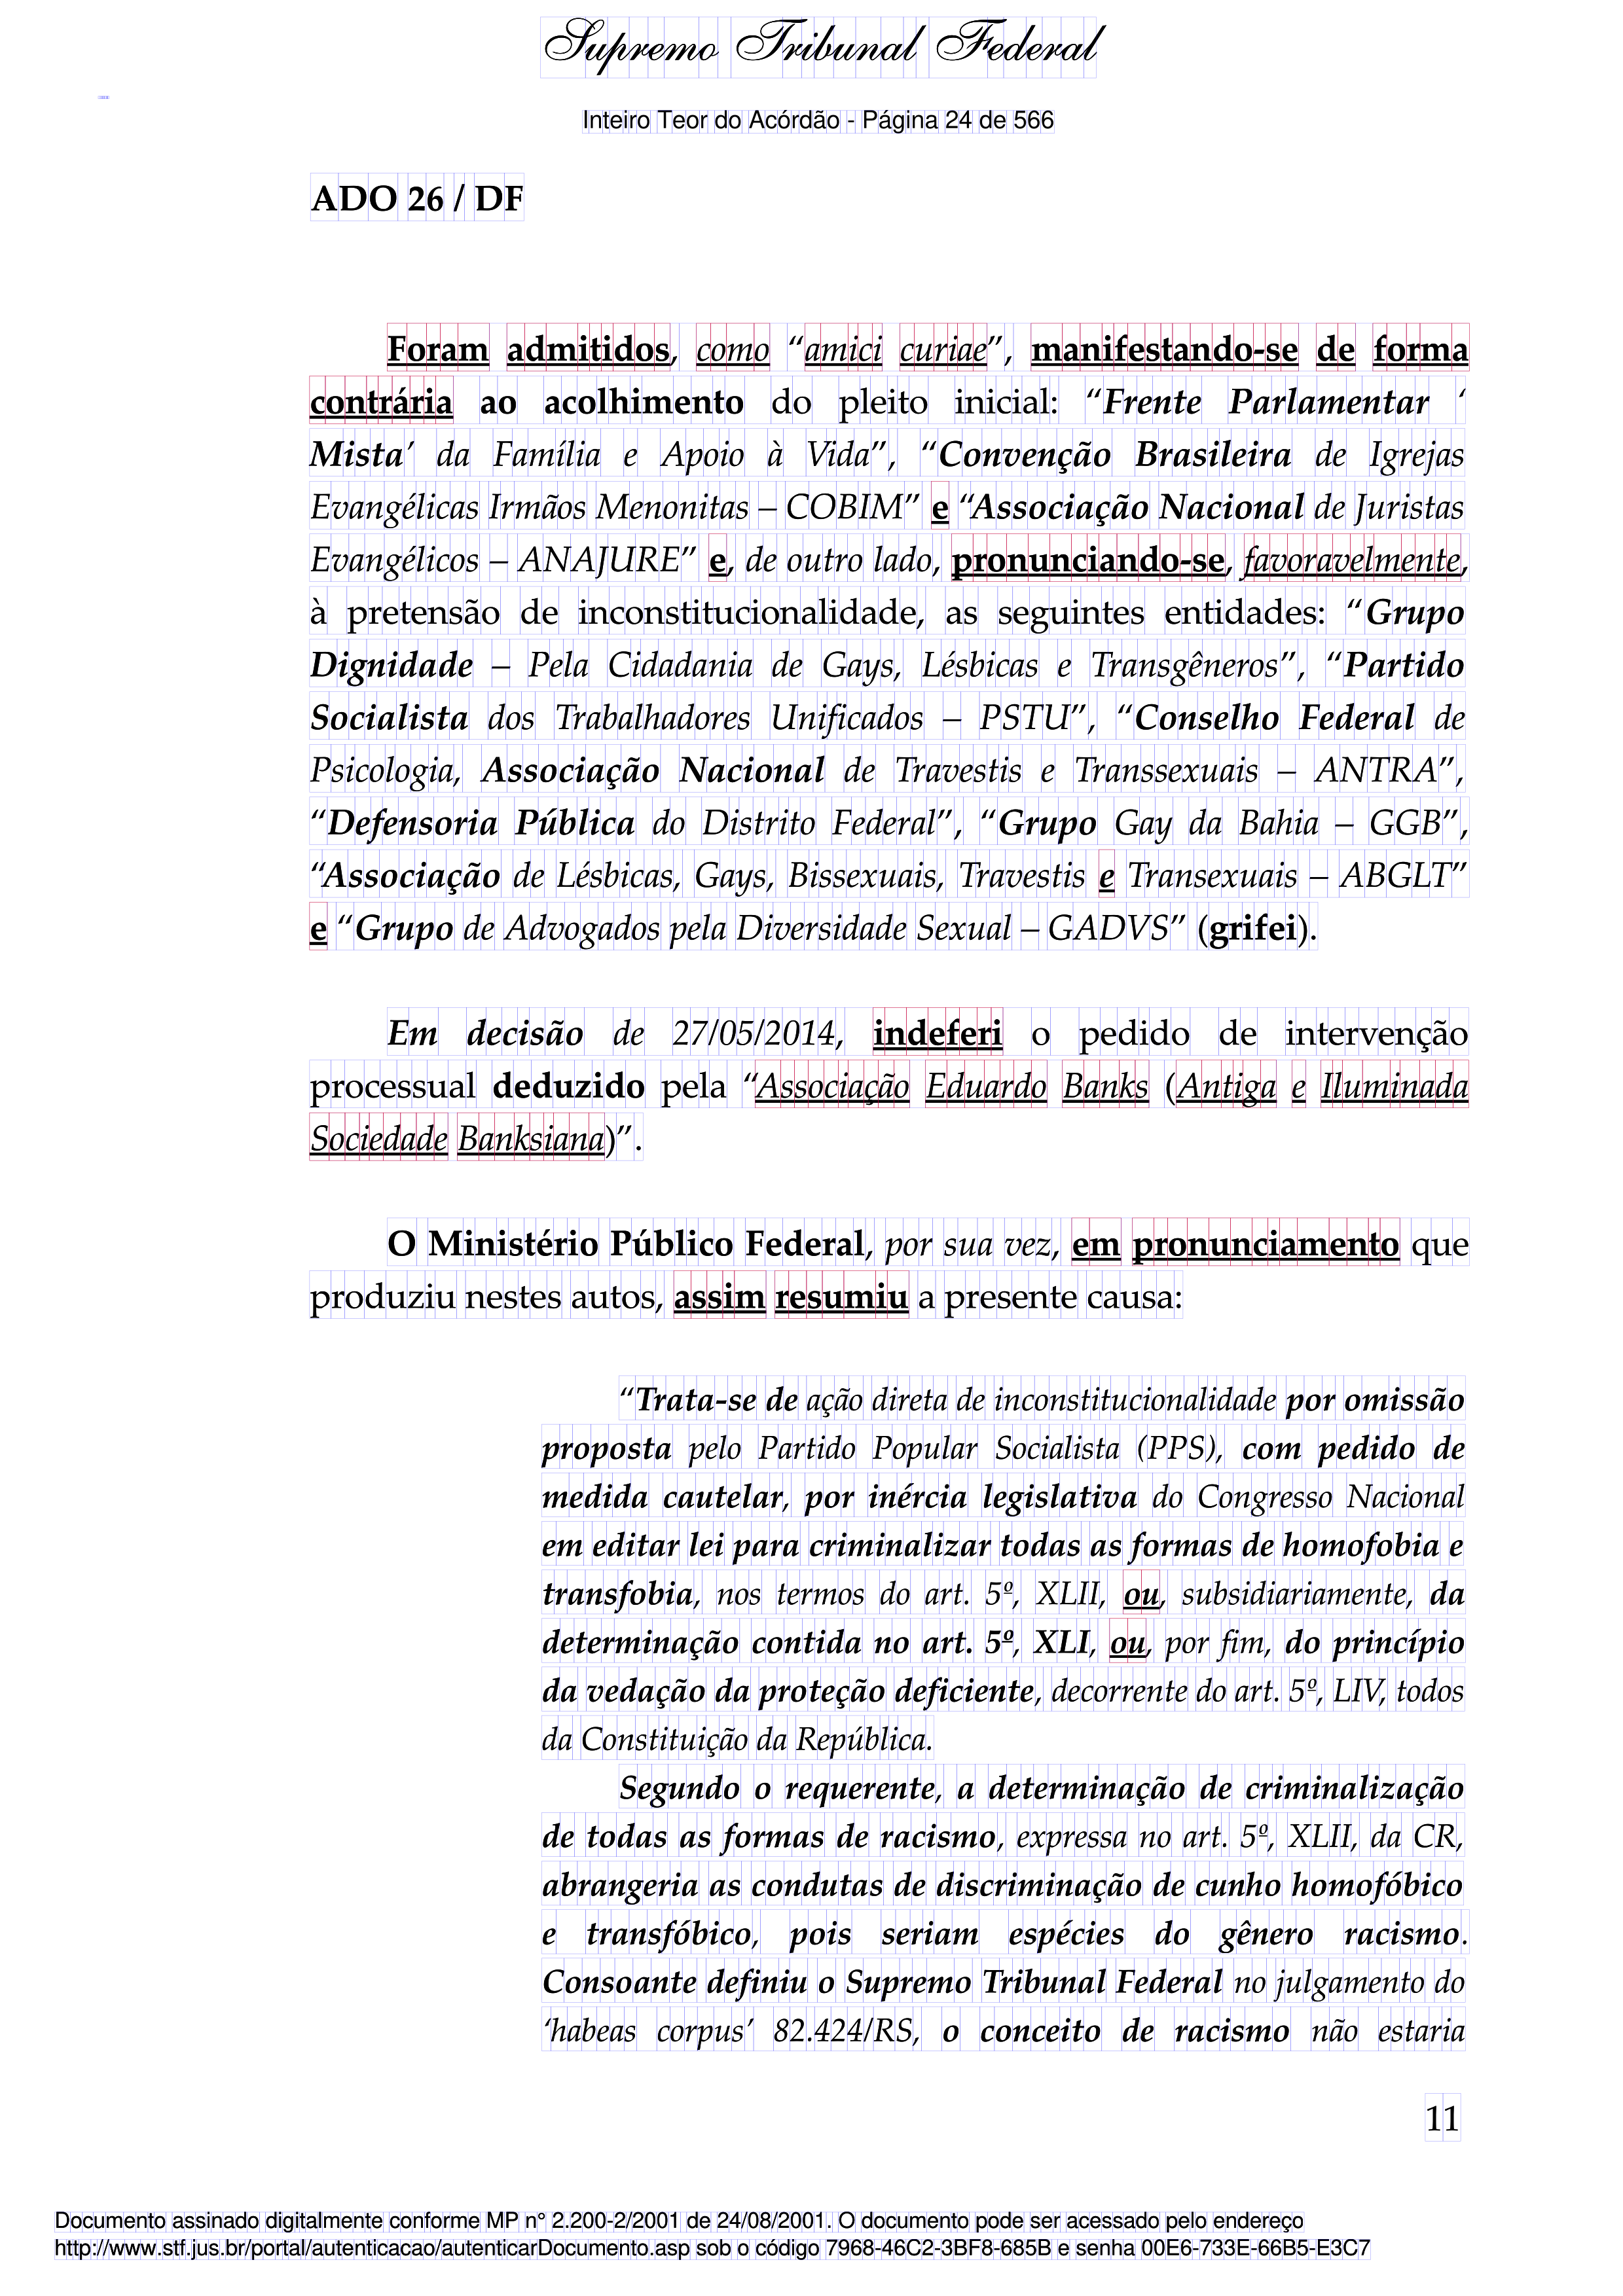

In [58]:
import gi
gi.require_version("Poppler", "0.18")
gi.require_foreign("cairo")
import base64

from gi.repository import Poppler, Gtk, Gio
import cairo

def open_pdf(filename: str):
    with open(filename, 'rb') as fp:
        input_stream = Gio.MemoryInputStream.new_from_data(fp.read())
        document = Poppler.Document.new_from_stream(input_stream, -1, None, None)
    return document

def render_page_to_cairo(page: Poppler.Page, dpi=300) -> (cairo.ImageSurface, cairo.Context, PIL.Image):
    #help(page)
    scaling_factor = dpi/72 # 1 inch = 72 points and PDF is in points
    width_in_points, height_in_points = page.get_crop_box().x2, page.get_crop_box().y2
    width_in_pixels, height_in_pixels = int(scaling_factor*width_in_points), int(scaling_factor*height_in_points)
    surface = cairo.ImageSurface(cairo.Format.RGB24, width_in_pixels, height_in_pixels)
    ctx = cairo.Context(surface)
    ctx.scale(width_in_pixels/width_in_points, height_in_pixels/height_in_points)
    ctx.save()
    ctx.set_source_rgba(1, 1, 1, 1)
    ctx.paint()
    ctx.restore()
    page.render(ctx)
    pil_img = PIL.Image.frombuffer("RGB", (surface.get_width(), surface.get_height()), bytes(surface.get_data()), "raw", "RGBA", 0, 1)
    return surface, ctx, pil_img

def render_page_num_to_cairo(document, page_num: int) -> (cairo.ImageSurface, cairo.Context):
    page = document.get_page(page_num - 1)
    return render_page_to_cairo(page)

def surface_to_data_uri(surface: cairo.ImageSurface) -> str:
    with tempfile.NamedTemporaryFile() as tmp:
        surface.write_to_png(tmp.name)
        tmp.seek(0)
        raw_data = tmp.read()
    return f'data:image/png;base64,{base64.b64encode(raw_data)}'

def surface_to_ipy_img(surface: cairo.ImageSurface):
    with tempfile.NamedTemporaryFile() as tmp:
        surface.write_to_png(tmp.name)
        tmp.seek(0)
        raw_data = tmp.read()
        output = IPython.display.Image(data=raw_data)
    return output
    
def surface_to_pil_img(surface: cairo.ImageSurface):
    with tempfile.NamedTemporaryFile() as tmp:
        surface.write_to_png(tmp.name)
        tmp.seek(0)
        output = PIL.Image.open(tmp.name)
    tmp.close()
    return output
    
def surface_to_matplotlib_img(surface: cairo.ImageSurface):
    with tempfile.NamedTemporaryFile() as tmp:
        surface.write_to_png(tmp.name)
        tmp.seek(0)
        output = matplotlib.image.imread(tmp.name)
    return output
    
@dataclass
class CharOnPage():
    page_num: int = None
    bbox: poppler.rectangle.Rectangle = None
    font_size: float = None
    font_name: str = None
    text: str = None

    def __repr__(self):
        return f'CharOnPage(page_num={self.page_num}, bbox={Rect2str(self.bbox)}, font_size={self.font_size}, font_name={self.font_name!r}, text={self.text!r})'

@dataclass
class Rect():
    left: float = None # x1
    bottom: float = None # y2
    right: float = None # x2
    top: float = None # y1
    
    @staticmethod
    def from_poppler(prect: Poppler.Rectangle):
        return Rect(prect.x1, prect.y2, prect.x2, prect.y1)
    
    def to_poppler(self) -> Poppler.Rectangle:
        prect = Poppler.Rectangle()
        prect.x1 = self.left
        prect.y1 = self.top
        prect.x2 = self.right
        prect.y2 = self.bottom
        return prect
    
    def width(self) -> float:
        return self.right-self.left
    
    def height(self) -> float:
        return self.bottom-self.top
    
    def __repr__(self):
        return f'Rect(x ∈ [{self.left:.2f}, {self.right:.2f}] y ∈ [{self.top:.2f}, {self.bottom:.2f}])'

def pcolor2hex(color: Poppler.Color):
    return f'#{color.red:02}{color.green:02}{color.blue:02}'

def page_to_chars(page: Poppler.Page):
    chars = []
    #help(page)
    page_text = page.get_text()
    for i, pos in enumerate(page.get_text_layout()[1]):
        chars.append((page_text[i], Rect.from_poppler(pos)))
    #for attr in page.get_text_attributes():
    #    print(attr.start_index, attr.end_index, pcolor2hex(attr.color), attr.font_name, attr.font_size, attr.is_underlined)
    #    print(f'{page_text[attr.start_index:attr.end_index+1]!r}')
    #    node_text=page_text[attr.start_index:attr.end_index+1]
    return chars
    

# ignore for now
def page_to_chars_and_image(document: Poppler.Document, page_num: int):
    page = document.get_page(page_num-1)
    chars = page_to_chars(page)
    surf, ctx = render_page_to_cairo(page)
    img = surface_to_ipy_img(surf)   
    return chars, img

def extract_rect_from_surface(ctx: cairo.Context, img: PIL.Image, rect: Rect) -> PIL.Image:
    (left, top) = ctx.user_to_device(rect.left, rect.top)
    (width, height) = ctx.user_to_device_distance(rect.width(), rect.height())
    #return ctx.get_target().create_for_rectangle(left, top, width, height)
    return img.crop((left, top, left+width, top+height))

def is_char_underlined(char_img: PIL.Image, debug=False) -> bool:
    # plan: count the number of dark pixels 
    # how: extract the region of interest to numpy and then do some fancy maths
    img = char_img.crop((0, char_img.height*0.82, char_img.width, 0.9*char_img.height))
    #img= char_img
    if debug:
        plt.imshow(img)
        plt.show()
    img_np = np.array(img.convert('L'))
    balck_pixels = np.count_nonzero(img_np <= 50)
    total_pixels = img_np.shape[0] * img_np.shape[1]
    if total_pixels == 0:
        return False
    if debug:
        print(img_np)
        print(balck_pixels, total_pixels, balck_pixels/total_pixels)
    black_percentage = balck_pixels/total_pixels
    return black_percentage > 0.6
    
def page_higlight_bounding_boxes(document: Poppler.Document, page_num: int, from_char:int=0, to_char:int=None, debug=False):
    page = document.get_page(page_num-1)
    chars = page_to_chars(page)
    surf, ctx, pil_img = render_page_to_cairo(page)
    
    if to_char is None:
        to_char = len(chars)+1
    
    char_surf = extract_rect_from_surface(ctx, pil_img, chars[90][1])
    print(is_char_underlined(char_surf, debug=True)) # should be true
    #char_surf = extract_rect_from_surface(ctx, chars[161][1])
    #print(is_char_underlined(char_surf)) # should be true
    #char_surf = extract_rect_from_surface(ctx, chars[162][1])
    #print(is_char_underlined(char_surf)) # should be false
    #char_surf = extract_rect_from_surface(ctx, chars[163][1])
    #print(is_char_underlined(char_surf)) # should be false
    
    for char in chars[from_char:to_char]:
        rect = char[1]
        ctx.save()
        ctx.rectangle(rect.left, rect.top, rect.width(), rect.height())
        ctx.set_source_rgba(0.0, 0.0, 1, 0.5)
        ctx.set_line_width(0.1)
        ctx.stroke()
        char_img = extract_rect_from_surface(ctx, pil_img, rect)
        if is_char_underlined(char_img):
            ctx.restore()
            ctx.rectangle(rect.left, rect.top, rect.width(), rect.height())
            ctx.set_source_rgba(1.0, 0.0, 0.0, 1)
            ctx.set_line_width(0.1)
            ctx.stroke()
            #is_char_underlined(char_img, debug=True)
        if debug:
            print(char)
    
    img = surface_to_ipy_img(surf)
    return chars, img
    
document = open_pdf('ado26.pdf')
_, img = page_higlight_bounding_boxes(document, 24)# from_char=160, to_char=170)
#_, img = page_higlight_bounding_boxes(document, 24)
display(img)

In [ ]:
assert False

#help(cairo.DrawingArea)
#help(poppler.document)
#help(Poppler.Document)
#print(dir(cairo))

page = document.get_page(0)
width, height = int(page.get_crop_box().x2), int(page.get_crop_box().y2)
print(width, height)
surface = cairo.ImageSurface(cairo.Format.ARGB32, width, height)
ctx = cairo.Context(surface)
page.render(ctx)

surface.write_to_png('test2a.png')
import matplotlib.pyplot as plt
img2 = np.ndarray(buffer=surface.get_data(), shape=(height, width), dtype=np.uint32)
print(img2)
plt.imshow(img2)
plt.show()

surface.write_to_png('test2.png')

Python.display.Image

#print(page.render.Area)
#renderer = Poppler.PageRenderer()
#renderer
#help(poppler)

In [ ]:
document = poppler.load_from_file("ado26.pdf")

In [ ]:
@dataclass
class CharOnPage():
    page_num: int = None
    bbox: poppler.rectangle.Rectangle = None
    font_size: float = None
    font_name: str = None
    text: str = None

    def __repr__(self):
        return f'CharOnPage(page_num={self.page_num}, bbox={Rect2str(self.bbox)}, font_size={self.font_size}, font_name={self.font_name!r}, text={self.text!r})'

def Rect2str(bbox: poppler.rectangle.Rectangle) -> str:
    return f'(x=[{bbox.left:.2f}, {bbox.right:.2f}] y=[{bbox.top:.2f}, {bbox.bottom:.2f}])'
    
def page_to_chars_and_image(document, page_num: int):
    page = document.create_page(page_num-1)
    chars = []
    for tb in page.text_list(page.TextListOption.text_list_include_font):
        #text, rotation, bbox = tb.text, tb.rotation, tb.bbox
        font_size = tb.get_font_size()
        for i in range(len(tb.text)):
            bbox = tb.char_bbox(i)
            font_name = tb.get_font_name(i)
            char = CharOnPage(page_num, bbox, font_size, font_name, tb.text[i])
            chars.append(char)
    renderer = poppler.PageRenderer()
    assert renderer.can_render()
    #print(renderer.)
    img = renderer.render_page(page)
    return chars, img

chars, img = page_to_chars_and_image(document, 2)
#help(img)
#img.supported_image_formats()


renderer = poppler.PageRenderer()
print(renderer.can_render())
renderer.render_page(document.create_page(2-1)).data[:20]

#from PIL import Image, ImageTk

#pil_image = Image.frombytes(
#    "RGBA",
#    (img.width, img.height),
#    img.data,
#    "raw",
#    str(img.format),
# )
#tk_image = ImageTk.PhotoImage(pil_image)

In [ ]:
import matplotlib.pyplot as plt
img2 = np.array(img.memoryview(), copy=False)
img2
#plt.imshow(img2)
#plt.show()

In [ ]:
page = document.create_page(2-1)
print(len(page.text_list()))

nodes = []
for tb in page.text_list(page.TextListOption.text_list_include_font):
    Δx, Δy = 0, 0
    if len(nodes) > 0:
        tb_old = nodes[-1][2]
        #Δx = tb.bbox.x - (tb_old.bbox.x + tb_old.bbox.width)
        Δx = tb_old.bbox.right - tb.bbox.left
        #Δy = (tb.bbox.y - tb_old.bbox.height) - (tb_old.bbox.y - tb_old.bbox.height)
        cy1 = (tb.bbox.bottom + tb.bbox.top)/2
        cy2 = (tb_old.bbox.bottom + tb_old.bbox.top)/2
        Δy = tb_old.bbox.bottom - tb.bbox.bottom
    else:
        pass
    nodes.append((Δx, Δy, tb))

for pair in nodes:
    Δx, Δy, tb = pair[0], pair[1], pair[2]
    bbox = tb.bbox
    #print(f'{bbox.bottom:9.2f} {bbox.top:9.2f} {bbox.left:9.2f} {bbox.right:9.2f} {tb.text!r}')
    x, y, w, h = tb.bbox.x, tb.bbox.y, tb.bbox.width, tb.bbox.height
    pos = f'({Δx:9.2f}, {Δy:9.2f}) | ({x:7.2f}, {y:7.2f}) + ({w:7.2f}, {h:7.2f})'
    print(f'{pos} {tb.text!r:20} {tb.get_font_size()} {tb.get_font_name()} ')
    #print(f'')

In [ ]:
Links = [
    'https://portal.stf.jus.br/processos/downloadPeca.asp?id=15344606459&ext=.pdf' #ADO 26
]

In [ ]:
#response = requests.get(Links[0])
#with open("ado26.pdf", "wb") as fp:
#   fp.write(response.content)

In [ ]:
TextNode = make_dataclass('TextNode', [
    ('page', int),
    ('x', float),
    ('y', float),
    ('font', str),
    ('size', float),
    ('bold', bool),
    ('italic', bool),
    ('text', str),
])

In [ ]:
reader = PdfReader("ado26.pdf")
page_num = 2
page = reader.pages[page_num-1]
nodes = []
def pdf_matrix2np(m):
    a,b,c,d,e,f = m[0], m[1], m[2], m[3], m[4], m[5]
    return np.array([[a,b,0],[c,d,0],[e,f,1]])
def visitor_body(text, cm, tm, font_dict, font_size):
    #if text is '':
    #    return
    font_dict = {} if font_dict is None else font_dict
    
    fm = pdf_matrix2np(cm) @ pdf_matrix2np(tm)
    x, y = fm[2][0], fm[2][1]
    font_face = font_dict.get('/BaseFont', '')
    bold = font_face.endswith('-Bold') or font_face.endswith('-BoldItalic')
    italic = font_face.endswith('-Italic') or font_face.endswith('-BoldItalic')
    node = TextNode(page_num,x,y,font_face,font_size,bold,italic,text)
    nodes.append(node)
    
def compare(node_a, node_b):
    if node_a.y > node_b.y:
        return -1
    elif node_a.x < node_b.x:
        return 1
    else:
        return 0
    
page.extract_text(visitor_text=visitor_body)
#nodes = sorted(nodes, key=lambda n: n.y, reverse=True)
nodes = sorted(nodes, key=functools.cmp_to_key(compare))
for node in nodes:
    print(node)
